# ElasticAST evaluated on VoxCeleb
All the evaluation logs can be observed below.

When doing it your self, please change the directory accordingly.

In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tqdm import tqdm


from models import FlexiAST_V2
import numpy as nps
from utilities import *

model = FlexiAST_V2(
    sample_size = (128,3072),
    patch_size = 16,
    num_classes = 1251,
    dim = 768,
    depth = 12,
    heads = 12,
    dropout = 0,
    emb_dropout = 0,
    token_dropout_prob = 0,  # token dropout of 10% (keep 90% of tokens)
    channels=1,
)


model_load = "/mnt/bear1/users/fj/FlexiAST_V2/flexiast2/voxceleb/VoxCeleb_flexi_len_pretrained-5-1-0.75-max3072-weightedNorm-SSAST-mid_norm/models/audio_model.30.pth"

out_dict = {}
state_dict = torch.load(model_load,map_location=torch.device('cpu'))
for k, v in state_dict.items(): # Adjust the name of dict
    out_dict[k[7:]] = v
model.load_state_dict(out_dict, strict=True)

/home/jfeng/anaconda3/envs/flexiast2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



<All keys matched successfully>

In [2]:
import dataloader


length = np.arange(128*2, 128*24+1,128)
# append two special cases
length = np.append(length, 400)
length = np.append(length, 1600)
length = np.sort(length)

quality_acc = []

batch_size = 12
mel_bins = 128
audio_length = 3072 # length upper bound
dataset = 'voxceleb'
Fshift = 10
window_size = 25
data_val = '/home/jfeng/FJ/FlexiAST/egs/voxceleb/data/datafile/test_data.json' # change to your own path
label_csv = '/home/jfeng/FJ/FlexiAST/egs/voxceleb/data/class_labels_indices.csv' # change to your own path
dataset_mean=-5.842545
dataset_std=3.88305


for l in length:
    val_audio_conf = {'num_mel_bins': mel_bins, 'target_length': l, 'freqm': 0, 'timem': 0, 'mixup': 0,
                'dataset': dataset, 'mode': 'evaluation', 'mean': dataset_mean, 'std': dataset_std, 'noise': False,
                'Fshift': Fshift,"window_size":window_size}
    val_loader = torch.utils.data.DataLoader(
        dataloader.FlexiLength_Dataset(data_val, label_csv=label_csv, audio_conf=val_audio_conf),
        batch_size=batch_size*2, shuffle=False, num_workers=8, pin_memory=True,collate_fn=dataloader.list_collate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        A_predictions = []
        A_targets = []
        A_loss = []
        with tqdm(val_loader) as vepoch:
            for data_items, labels in vepoch:
                data_items, labels = data_items, labels
                for i in range(len(data_items)):
                    data_items[i] = data_items[i].to(device)
                outputs = model(data_items,group_samples=True,group_max_seq_len=2048)
                outputs = torch.sigmoid(outputs)
                predictions = outputs.to('cpu').detach()

                A_predictions.append(predictions)
                A_targets.append(labels)

                labels = labels.to(device)


        outputs = torch.cat(A_predictions)
        labels = torch.cat(A_targets)
        stats = calculate_stats(outputs, labels)

    mAP = np.mean([stat['AP'] for stat in stats])
    acc = stats[0]['acc']
    print(f"Quality ratio: {l}, mAP: {mAP}, acc: {acc}")
    quality_acc.append(acc)

print(quality_acc)

---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:18<00:00, 18.77it/s]


Quality ratio: 256, mAP: 0.41682441901184614, acc: 0.44661253181432553
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:22<00:00, 15.47it/s]


Quality ratio: 384, mAP: 0.5017860764529434, acc: 0.5235729002545146
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:23<00:00, 14.57it/s]


Quality ratio: 400, mAP: 0.505423775092782, acc: 0.532420312689371
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:23<00:00, 14.50it/s]


Quality ratio: 512, mAP: 0.5364033649251138, acc: 0.5607805114531572
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:30<00:00, 11.35it/s]


Quality ratio: 640, mAP: 0.5489534916408808, acc: 0.5715670827778451
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:31<00:00, 10.88it/s]


Quality ratio: 768, mAP: 0.5550744134528538, acc: 0.580050902920858
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:33<00:00, 10.13it/s]


Quality ratio: 896, mAP: 0.559511351440597, acc: 0.588534723063871
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:35<00:00,  9.71it/s]


Quality ratio: 1024, mAP: 0.5627356007179496, acc: 0.5893831050781724
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:36<00:00,  9.46it/s]


Quality ratio: 1152, mAP: 0.5651300903254801, acc: 0.5924130408435341
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:37<00:00,  9.27it/s]


Quality ratio: 1280, mAP: 0.5673391111064641, acc: 0.5935038177190644
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:37<00:00,  9.09it/s]


Quality ratio: 1408, mAP: 0.568797238726387, acc: 0.5944733971639802
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:38<00:00,  8.93it/s]


Quality ratio: 1536, mAP: 0.5681480087442848, acc: 0.5947157920252091
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:38<00:00,  8.87it/s]


Quality ratio: 1600, mAP: 0.5679405972962246, acc: 0.5948369894558235
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:39<00:00,  8.82it/s]


Quality ratio: 1664, mAP: 0.567893242943443, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:39<00:00,  8.72it/s]


Quality ratio: 1792, mAP: 0.5685620358253537, acc: 0.5945945945945946
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:39<00:00,  8.66it/s]


Quality ratio: 1920, mAP: 0.5684342929503999, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:39<00:00,  8.62it/s]


Quality ratio: 2048, mAP: 0.5685657040325645, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:40<00:00,  8.53it/s]


Quality ratio: 2176, mAP: 0.5684833839307813, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:41<00:00,  8.23it/s]


Quality ratio: 2304, mAP: 0.568638901940827, acc: 0.5939886074415223
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.11it/s]


Quality ratio: 2432, mAP: 0.5686411433126484, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.06it/s]


Quality ratio: 2560, mAP: 0.5685190840536976, acc: 0.5943521997333656
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.03it/s]


Quality ratio: 2688, mAP: 0.5684467760703569, acc: 0.5941098048721367
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.09it/s]


Quality ratio: 2816, mAP: 0.5685828337436798, acc: 0.5939886074415223
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.07it/s]


Quality ratio: 2944, mAP: 0.5684403885661102, acc: 0.5939886074415223
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb
use dataset mean -5.843 and std 3.883 to normalize the input.
number of classes is 1251
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 344/344 [00:42<00:00,  8.02it/s]


Quality ratio: 3072, mAP: 0.568407489243745, acc: 0.5939886074415223
[0.44661253181432553, 0.5235729002545146, 0.532420312689371, 0.5607805114531572, 0.5715670827778451, 0.580050902920858, 0.588534723063871, 0.5893831050781724, 0.5924130408435341, 0.5935038177190644, 0.5944733971639802, 0.5947157920252091, 0.5948369894558235, 0.5943521997333656, 0.5945945945945946, 0.5943521997333656, 0.5943521997333656, 0.5943521997333656, 0.5939886074415223, 0.5943521997333656, 0.5943521997333656, 0.5941098048721367, 0.5939886074415223, 0.5939886074415223, 0.5939886074415223]


In [4]:
baseline_1024 = [0.3684401891, 0.5022421525, 0.5124227366, 0.5649012241, 0.587686341, 0.5941098049, 0.5928978306, 0.5928978306, 0.5901102897, 0.5811416798, 0.5721730699, 0.5515695067, 0.5413889226, 0.5307235487, 0.5041813114, 0.4749727306, 0.4347351836, 0.4257665737, 0.3977699673, 0.3736516786, 0.3490486002, 0.3278390498, 0.3069930917, 0.2876015028, 0.2848139619]
baseline_400  = [0.4262513635, 0.4805478124, 0.4897588171, 0.4822445764, 0.4674584899, 0.434856381, 0.3931644649, 0.350139377, 0.3050539329, 0.2694218883, 0.2363349897, 0.209671555, 0.193915889, 0.1889467943, 0.1708883772, 0.1554963035, 0.1426493758, 0.1334383711, 0.1190158769, 0.1087140953, 0.1016846443, 0.09598836505, 0.09247363956, 0.08386862199, 0.08144467337]
baseline_1600 = [0.3245667192, 0.4637013695, 0.4747303357, 0.5379953945, 0.5703551085, 0.5828384438, 0.5936250151, 0.5935038177, 0.5943521997, 0.5953217792, 0.5948369895, 0.5932614229, 0.5966549509, 0.5937462126, 0.5862319719, 0.5778693492, 0.5739910314, 0.5682947522, 0.5532662708, 0.542358502, 0.525754454, 0.5086656163, 0.4984850321, 0.4822445764, 0.4679432796]
len_cut_flexi = [0.44661253181432553, 0.5235729002545146, 0.532420312689371, 0.5607805114531572, 0.5715670827778451, 0.580050902920858, 0.588534723063871, 0.5893831050781724, 0.5924130408435341, 0.5935038177190644, 0.5944733971639802, 0.5947157920252091, 0.5948369894558235, 0.5943521997333656, 0.5945945945945946, 0.5943521997333656, 0.5943521997333656, 0.5943521997333656, 0.5939886074415223, 0.5943521997333656, 0.5943521997333656, 0.5941098048721367, 0.5939886074415223, 0.5939886074415223, 0.5939886074415223]

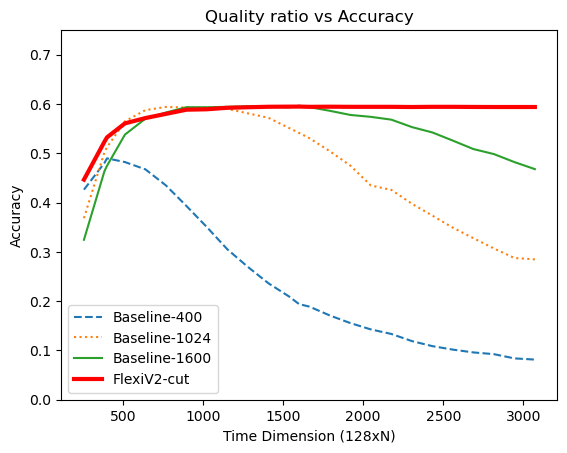

In [5]:
# draw the plot
import matplotlib.pyplot as plt
plt.plot(length, baseline_400, label="Baseline-400",linestyle='--')
plt.plot(length, baseline_1024, label="Baseline-1024",linestyle=':')
plt.plot(length, baseline_1600, label="Baseline-1600",linestyle='-')
plt.plot(length, len_cut_flexi, label="FlexiV2-cut",color='r',linewidth=3)


plt.legend()
plt.xlabel("Time Dimension (128xN)")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Different Natural Time Lengths")

plt.ylim(0.0, 0.75)

plt.show()